### Code blocks (12 pts)

In [6]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def attention(Q, K, V):
    """
    SoftMax(Q @ K.T / sqrt dim_attn) @ V
    Q, K, V = d_model x d_model
    """
    scores = torch.matmul(Q, K.transpose(-2, -1) / np.sqrt(Q.size(-1)))
    attn = F.softmax(scores, dim=-1)
    return torch.matmul(attn,  V)

class AttentionBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Q = nn.Linear(d_model, d_model, bias=False)
        self.K = nn.Linear(d_model, d_model, bias=False)
        self.V = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x):
        """
        input:  x - [batch_size x seq_len x d_model] - embeddings
        output: z - [batch_size x seq_len x d_model] - attentions
        """
        attn = attention(self.Q(x), self.K(x), self.V(x))
        return attn
    
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.Sequential(*[
            AttentionBlock(d_model) for i in range(n_heads)
        ])
        self.W = nn.Linear(n_heads * d_model, d_model, bias=False)

    def forward(self, x):
        """
        input:  x - [batch_size x seq_len x d_model] - embeddings
        output: z - [batch_size x seq_len x d_model] - attentions
        """
        attn = [h(x) for h in self.heads]
        attn = torch.stack(attn, dim=-1).flatten(2)
        z = self.W(attn)
        return z

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = MultiHeadAttentionBlock(d_model, n_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    
    def forward(self, x):
        """
        input:  x - [batch_size x seq_len x d_model] - embeddings
        output: z - [batch_size x seq_len x d_model] - hidden state
        """
        attn = self.attn(x)
        x = self.norm1(x + attn)
        attn = self.feedforward(x)
        x = self.norm2(x + attn)
        return x
    
class Encoder(nn.Module):
    def __init__(self, d_model, n_heads, depth):
        super().__init__()
        self.net = nn.Sequential(*[
            EncoderLayer(d_model, n_heads) for i in range(depth)
        ])
        
    def forward(self, x):
        """
        input:  x - [batch_size x d_model x seq_len] - embeddings
        output: z - [batch_size x seq_len x d_model] - hidden state
        """
        return self.net(x.transpose(-2, -1)) 
    
class ClassificationHead(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 2), 
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        """
        input:  x - [batch_size x seq_len x d_model] - hidden state
        output: z - [batch_size x 2] - probabilities
        """
        out = torch.mean(x, dim=1)
        return self.net(out)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(1, d_model, max_len).to(device)
        position = torch.arange(0, max_len).unsqueeze(0).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term[:, None])
        pe[:, 1::2] = torch.cos(position * div_term[:, None])
        self.pe = pe

    def forward(self, x):
        x = x + self.pe[:, :, :x.size(-1)]
        return self.dropout(x)
    
class Transformer(nn.Module):
    def __init__(self, seq_len, d_model, n_heads, depth):
        super().__init__()
        self.norm = nn.LayerNorm(seq_len)
        self.channel_attn = ChannelAttention(seq_len, d_model)
        self.pos_encoder = PositionalEncoding(d_model, seq_len)
        self.encoder = Encoder(d_model, n_heads, depth)
        self.classifier = ClassificationHead(seq_len, d_model)
        
    def forward(self, x):
        """
        input:  x - [batch_size x 1 x d_model x seq_len] - signals
        output: z - [batch_size x 2] - probabilities
        """
        x = x.squeeze(1)
        out = self.norm(x)
        out = self.pos_encoder(out)
        out = self.encoder(out)
        out = self.classifier(out)
        return out

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)


In [9]:
def train_epoch(model, trainloader, optimizer, criterion, augmentation=False):
    loss_per_epoch = 0.0
    accr_per_epoch = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), leave=False)
    for i, batch in pbar:
        x, y = batch
        x, y = x.to(device), y.to(device)
        if augmentation:
            indx = torch.randint(0, 2, (x.size(0), 1, 1, 1)).to(device)
            noise = torch.randn_like(x).to(device) * 0.1 * indx
            x += noise
        probs = model(x)
        loss = criterion(probs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accr = (probs.argmax(1) == y).sum() / len(y)
        loss_per_epoch += loss.item()
        accr_per_epoch += accr.item()
        res = f'Loss {loss_per_epoch/(i+1):.4f} | Accuracy {100*accr_per_epoch/(i+1):.2f}%'
        pbar.set_description('Train: ' + res)
    loss_per_epoch /= i+1
    accr_per_epoch /= i+1
    return loss_per_epoch, accr_per_epoch

def test(model, testloader, criterion):
    model.eval()
    total_loss = 0.0
    total_accr = 0.0
    total_preds = []
    total_y = []
    with torch.no_grad():
        for batch in tqdm(testloader, desc='Test', leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            preds = probs.argmax(1)
            accr = (preds == y).sum() / len(y)
            total_preds.extend(preds.detach().cpu().numpy())
            total_y.extend(y.detach().cpu().numpy())
            total_loss += loss.item()
            total_accr += accr.item()
    total_loss /= len(testloader)
    total_accr /= len(testloader)
    return total_loss, total_accr, total_preds, total_y
            
def train(model, trainloader, testloader, optimizer, n_epochs, augmentation=False):
    model.train()
    history = {
        'train loss': [], 'train accuracy': [], 
        'test loss': [], 'test accuracy': []
    }
    for i in range(n_epochs):
        train_loss, train_accr = train_epoch(model, trainloader, optimizer, criterion, augmentation)
        test_loss, test_accr, total_preds, total_y = test(model, testloader, criterion)
        res = f'Epoch {i} | '
        res += f'Train Loss {train_loss:.4f} | Train Accuracy {100*train_accr:.2f}% | '
        res += f'Test Loss {test_loss:.4f} | Test Accuracy {100*test_accr:.2f}%'
        print(res)
        history['train loss'].append(train_loss)
        history['train accuracy'].append(train_accr)
        history['test loss'].append(test_loss)
        history['test accuracy'].append(test_accr)
#         torch.save(self.model.state_dict(), 'model_vit.pth')
    return {
        'test accuracy': test_accr,
        'predictions': total_preds,
        'true labels': total_y,
        'history': history
    }

#### Datasets

In [10]:
test_length = int(len(dataset)*0.3)
lengths = [len(dataset)-test_length, test_length]
trainset, testset = torch.utils.data.random_split(dataset, lengths)
    
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

#### Train

In [11]:
net = Transformer(seq_len=160, d_model=64, n_heads=4, depth=6).to(device)
optimizer = Adam(net.parameters(), lr=4e-5)#, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()
aug_results = train(net, trainloader, testloader, optimizer, n_epochs=30, augmentation=True)

  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0 | Train Loss 0.6915 | Train Accuracy 52.04% | Test Loss 0.6867 | Test Accuracy 54.74%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Train Loss 0.6828 | Train Accuracy 55.26% | Test Loss 0.6782 | Test Accuracy 56.14%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Train Loss 0.6766 | Train Accuracy 56.74% | Test Loss 0.6933 | Test Accuracy 53.33%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Train Loss 0.6728 | Train Accuracy 57.79% | Test Loss 0.6719 | Test Accuracy 57.81%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Train Loss 0.6691 | Train Accuracy 58.80% | Test Loss 0.6700 | Test Accuracy 58.26%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Train Loss 0.6652 | Train Accuracy 59.29% | Test Loss 0.6671 | Test Accuracy 59.08%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Train Loss 0.6636 | Train Accuracy 59.41% | Test Loss 0.6655 | Test Accuracy 59.80%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Train Loss 0.6604 | Train Accuracy 60.39% | Test Loss 0.6661 | Test Accuracy 59.15%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Train Loss 0.6582 | Train Accuracy 60.63% | Test Loss 0.6760 | Test Accuracy 57.97%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Train Loss 0.6548 | Train Accuracy 61.39% | Test Loss 0.6626 | Test Accuracy 60.00%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Train Loss 0.6529 | Train Accuracy 61.64% | Test Loss 0.6637 | Test Accuracy 60.09%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Train Loss 0.6503 | Train Accuracy 62.08% | Test Loss 0.6647 | Test Accuracy 60.06%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Train Loss 0.6475 | Train Accuracy 62.68% | Test Loss 0.6609 | Test Accuracy 60.57%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Train Loss 0.6459 | Train Accuracy 63.01% | Test Loss 0.6613 | Test Accuracy 60.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Train Loss 0.6431 | Train Accuracy 63.34% | Test Loss 0.6588 | Test Accuracy 61.14%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Train Loss 0.6397 | Train Accuracy 63.74% | Test Loss 0.6629 | Test Accuracy 60.25%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Train Loss 0.6384 | Train Accuracy 64.13% | Test Loss 0.6582 | Test Accuracy 61.05%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Train Loss 0.6340 | Train Accuracy 64.63% | Test Loss 0.6720 | Test Accuracy 59.44%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Train Loss 0.6333 | Train Accuracy 65.03% | Test Loss 0.6620 | Test Accuracy 60.32%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Train Loss 0.6300 | Train Accuracy 65.44% | Test Loss 0.6597 | Test Accuracy 61.23%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Train Loss 0.6294 | Train Accuracy 65.16% | Test Loss 0.6703 | Test Accuracy 59.58%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Train Loss 0.6248 | Train Accuracy 66.25% | Test Loss 0.6576 | Test Accuracy 61.77%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Train Loss 0.6228 | Train Accuracy 66.22% | Test Loss 0.6639 | Test Accuracy 60.73%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Train Loss 0.6217 | Train Accuracy 66.54% | Test Loss 0.6563 | Test Accuracy 61.83%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Train Loss 0.6172 | Train Accuracy 67.11% | Test Loss 0.6592 | Test Accuracy 61.41%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Train Loss 0.6134 | Train Accuracy 67.80% | Test Loss 0.6643 | Test Accuracy 61.16%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Train Loss 0.6113 | Train Accuracy 68.00% | Test Loss 0.6574 | Test Accuracy 62.08%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Train Loss 0.6089 | Train Accuracy 68.26% | Test Loss 0.6558 | Test Accuracy 61.91%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Train Loss 0.6031 | Train Accuracy 68.94% | Test Loss 0.6584 | Test Accuracy 61.92%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Train Loss 0.6042 | Train Accuracy 68.63% | Test Loss 0.6572 | Test Accuracy 62.01%


In [12]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


def show_plots(results):
    _, ax = plt.subplots(1, 2, figsize=(10, 3))

    ax[0].set_title('Loss')
    ax[0].plot(results['history']['train loss'], '-o', c='b', label='train')
    ax[0].plot(results['history']['test loss'], '-o', c='r', label='test')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].set_title('Accuracy')
    ax[1].plot(results['history']['train accuracy'], '-o', c='b', label='train')
    ax[1].plot(results['history']['test accuracy'], '-o', c='r', label='test')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    
    plt.show()

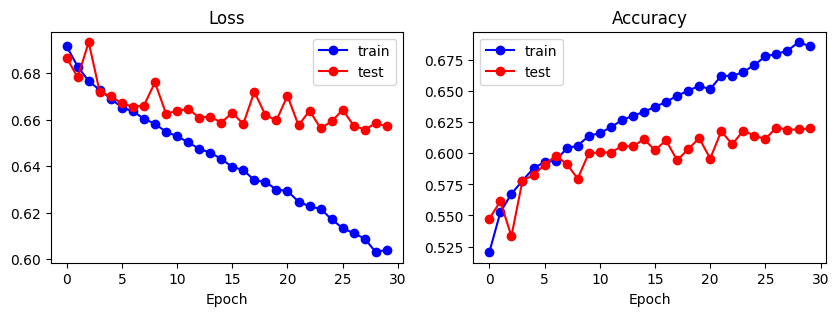

In [13]:
show_plots(aug_results)

In [14]:
def f1_confusion_matrix(results):
    f1 = f1_score(results['predictions'], results['true labels'])
    print(f'f1 score: {f1:.4f}')

    _, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.set_title('Confusion Matrix')
    cfm = confusion_matrix(results['predictions'], results['true labels'])
    ConfusionMatrixDisplay(cfm/cfm.sum()).plot(ax=ax, colorbar=False)
    plt.show()

f1 score: 0.5925


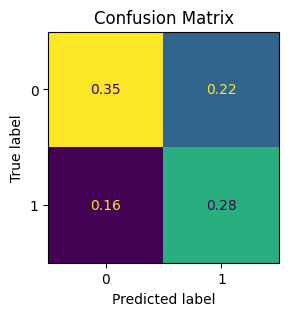

In [15]:
f1_confusion_matrix(aug_results)

Let's check it without augmentations:

In [17]:
net = Transformer(seq_len=160, d_model=64, n_heads=4, depth=6, channel_attn_flag=True, patch_embed_flag=False).to(device)
optimizer = Adam(net.parameters(), lr=4e-5)#, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()
results = train(net, trainloader, testloader, optimizer, n_epochs=30)

  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0 | Train Loss 0.6938 | Train Accuracy 50.94% | Test Loss 0.6920 | Test Accuracy 50.70%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 | Train Loss 0.6877 | Train Accuracy 53.81% | Test Loss 0.6787 | Test Accuracy 57.28%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 | Train Loss 0.6732 | Train Accuracy 57.43% | Test Loss 0.6872 | Test Accuracy 55.25%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 | Train Loss 0.6647 | Train Accuracy 59.37% | Test Loss 0.6679 | Test Accuracy 58.96%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 | Train Loss 0.6594 | Train Accuracy 60.26% | Test Loss 0.6634 | Test Accuracy 59.18%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 | Train Loss 0.6559 | Train Accuracy 60.98% | Test Loss 0.6615 | Test Accuracy 59.77%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 | Train Loss 0.6527 | Train Accuracy 61.44% | Test Loss 0.6604 | Test Accuracy 60.15%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 | Train Loss 0.6496 | Train Accuracy 61.80% | Test Loss 0.6576 | Test Accuracy 60.17%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 | Train Loss 0.6467 | Train Accuracy 62.21% | Test Loss 0.6578 | Test Accuracy 60.10%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 | Train Loss 0.6427 | Train Accuracy 63.04% | Test Loss 0.6569 | Test Accuracy 60.77%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 | Train Loss 0.6412 | Train Accuracy 63.17% | Test Loss 0.6723 | Test Accuracy 58.95%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11 | Train Loss 0.6391 | Train Accuracy 63.51% | Test Loss 0.6541 | Test Accuracy 61.38%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12 | Train Loss 0.6375 | Train Accuracy 63.80% | Test Loss 0.6521 | Test Accuracy 61.72%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13 | Train Loss 0.6350 | Train Accuracy 64.11% | Test Loss 0.6535 | Test Accuracy 61.50%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14 | Train Loss 0.6311 | Train Accuracy 64.82% | Test Loss 0.6543 | Test Accuracy 61.51%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15 | Train Loss 0.6292 | Train Accuracy 65.10% | Test Loss 0.6596 | Test Accuracy 60.56%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16 | Train Loss 0.6271 | Train Accuracy 65.33% | Test Loss 0.6530 | Test Accuracy 61.46%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17 | Train Loss 0.6231 | Train Accuracy 65.98% | Test Loss 0.6525 | Test Accuracy 61.86%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18 | Train Loss 0.6198 | Train Accuracy 66.51% | Test Loss 0.6589 | Test Accuracy 61.00%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19 | Train Loss 0.6178 | Train Accuracy 66.81% | Test Loss 0.6522 | Test Accuracy 61.83%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20 | Train Loss 0.6130 | Train Accuracy 67.54% | Test Loss 0.6518 | Test Accuracy 61.95%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21 | Train Loss 0.6103 | Train Accuracy 67.63% | Test Loss 0.6738 | Test Accuracy 60.14%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22 | Train Loss 0.6093 | Train Accuracy 68.00% | Test Loss 0.6561 | Test Accuracy 61.78%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23 | Train Loss 0.6032 | Train Accuracy 68.78% | Test Loss 0.6543 | Test Accuracy 62.51%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24 | Train Loss 0.6002 | Train Accuracy 69.31% | Test Loss 0.6531 | Test Accuracy 62.47%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25 | Train Loss 0.6009 | Train Accuracy 69.26% | Test Loss 0.6552 | Test Accuracy 62.04%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26 | Train Loss 0.5946 | Train Accuracy 69.96% | Test Loss 0.6506 | Test Accuracy 62.46%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27 | Train Loss 0.5900 | Train Accuracy 70.54% | Test Loss 0.6531 | Test Accuracy 63.16%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28 | Train Loss 0.5898 | Train Accuracy 70.64% | Test Loss 0.6506 | Test Accuracy 63.20%


  0%|          | 0/437 [00:00<?, ?it/s]

Test:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29 | Train Loss 0.5846 | Train Accuracy 71.40% | Test Loss 0.6543 | Test Accuracy 62.96%


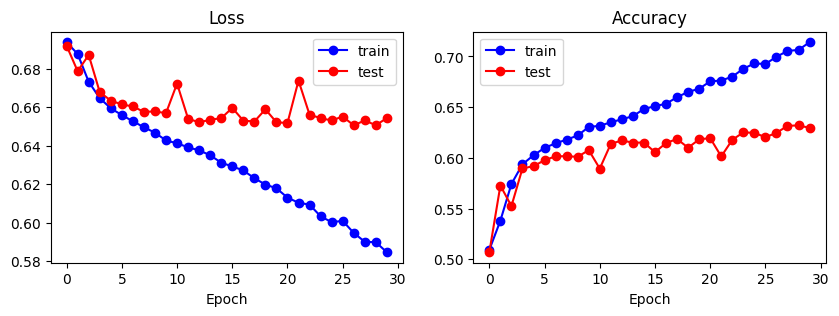

In [18]:
show_plots(results)

f1 score: 0.5860


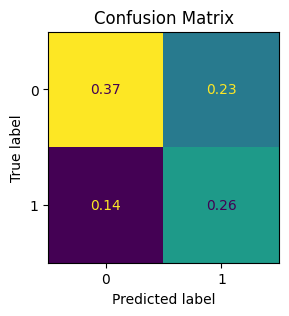

In [19]:
f1_confusion_matrix(results)

Let's compare

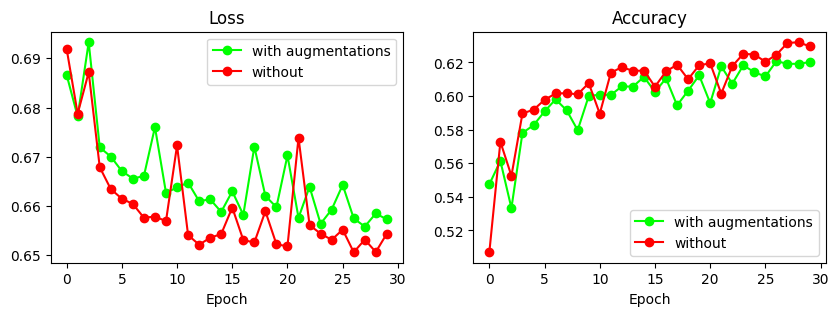

In [20]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].set_title('Loss')
ax[0].plot(aug_results['history']['test loss'], '-o', c='lime', label='with augmentations')
ax[0].plot(results['history']['test loss'], '-o', c='r', label='without')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(aug_results['history']['test accuracy'], '-o', c='lime', label='with augmentations')
ax[1].plot(results['history']['test accuracy'], '-o', c='r', label='without')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

Seems like it's better to use augmentation to prevent overfitting.

### Efficient transformers (10 pts)

One of the key issues in a transformer is its quadratic complexity in relation to the length of the input sequence. This quadratic complexity can be computationally expensive, making it harder to scale transformers to longer sequences. Specifically, computing the attention matrix requires an $O(N^2)$ operation per layer, where $N$ is the length of the input sequence. This makes training and inference for large input sequences infeasible due to limitations in the available computational resources. 


Propose 2 implementation of eficient transformers, provide references and main idea of selected approaches. (2 pts)

Implement one of the approaches, compare inference with the previous model, make a conclusion. (8 pts)


**Small Improvements**: 

The authors of one article call for the use of `ChannelAttention`, which is designed to reweigh the data along the channels according to some cramp coming from this layer. In the following image, this step follows the Spatial Filter.

![fig](https://user-images.githubusercontent.com/19758589/123399456-35aac100-d5d7-11eb-87ea-d480765df6b7.png)

Moreover, they proposed to use patching to crop our input data into smaller pieces. It can be used also for reducing size of the input. It works as follows: $x$ of shape [batch_size x channels x seq len] $\rightarrow$ [H, btach_size, patch size]. Here `patch size` is significantly smaller than a `seq len`. That's how we can reduce the inner matrices for one way.

In [11]:
class ChannelAttention(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.Q = nn.Linear(d_model, d_model, bias=False)
        self.K = nn.Linear(d_model, d_model, bias=False)
        self.projection = nn.Sequential(
            nn.Linear(d_model, d_model, bias=False), 
            nn.LayerNorm(d_model), 
            nn.Dropout(0.3),
        )
#         self.pooling = nn.AvgPool2d(kernel_size=(1, 30), stride=(1, 30))
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        """
        input:  x - [batch_size x d_model x seq_len] - hidden state
        output: z - [batch_size x d_model x seq_len] - probabilities
        """
        x_t = x.transpose(-2, -1)
        Q = self.Q(x_t).transpose(-2, -1)
        K = self.K(x_t).transpose(-2, -1)
        score = torch.matmul(Q, K.transpose(-2, -1) / np.sqrt(Q.size(-1)))
        attn = F.softmax(score, dim=-1).transpose(-2, -1)
        out = torch.matmul(x_t, attn)
        out = self.projection(out).transpose(-2, -1)
        # save
        self.out = out
        self.score = score
        return out
    
class PatchEmbedding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=(1, 51)),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2, d_model, kernel_size=(31, 31), stride=(1, 5))
        )
        
    def forward(self, x):
        """
        input:  x - [batch_size x d_model x seq_len] - embeddings
        output: z - [ x d_model x batch_size x d_model] - embeddings
        """
        out = self.projection(x.unsqueeze(1))
        out = out.flatten(2).permute(2, 0, 1)
        return out
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.5)
        
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.pe = nn.Parameter(pe, requires_grad=True)
        
        self.pe = nn.Parameter(torch.zeros(max_len, 1, d_model), requires_grad=True)
        
    def forward(self, x):
#         x = x + self.pe[:, :x.size(1)] 
        x = x + self.pe[:x.shape[0]]
        x = self.dropout(x).transpose(-2, -1)
        return x
    

class ViT(nn.Module):
    def __init__(
        self, seq_len, d_model, n_heads, depth, 
        channel_attn_flag=False, 
        patch_embed_flag=False,
    ):
        super().__init__()
        self.channel_attn_flag = channel_attn_flag
        self.patch_embed_flag = patch_embed_flag
        
        self.norm = nn.LayerNorm(seq_len)
        self.channel_attn = ChannelAttention(seq_len, d_model)
        self.drop_out = nn.Dropout(0.5)
        self.patch_embed = PatchEmbedding(d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(d_model, n_heads, depth)
        self.classifier = ClassificationHead(seq_len, d_model)
        
    def forward(self, x):
        """
        input:  x - [batch_size x 1 x d_model x seq_len] - signals
        output: z - [batch_size x 2] - probabilities
        """
        x = x.squeeze(1)
        out = self.norm(x)
#         out = self.channel_attn(out)
#         out = x + self.drop_out(out)
        out = self.patch_embed(out)
        out = self.pos_encoder(out)
        out = self.encoder(out)
        out = torch.mean(out, 0, keepdims=True).transpose(0, 1)
        out = self.classifier(out)
        return out

In [12]:
net = ViT(seq_len=160, d_model=64, n_heads=4, depth=6, channel_attn_flag=True).to(device)
optimizer = Adam(net.parameters(), lr=4e-4)#, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()
vit_results = train(net, trainloader, testloader, optimizer, n_epochs=3)

  0%|          | 0/874 [00:00<?, ?it/s]

Test:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 0 | Train Loss 0.6956 | Train Accuracy 50.04% | Test Loss 0.6931 | Test Accuracy 50.52%


  0%|          | 0/874 [00:00<?, ?it/s]

Test:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 | Train Loss 0.6940 | Train Accuracy 49.93% | Test Loss 0.6934 | Test Accuracy 49.70%


  0%|          | 0/874 [00:00<?, ?it/s]

Test:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 | Train Loss 0.6938 | Train Accuracy 50.01% | Test Loss 0.6945 | Test Accuracy 50.23%


Seems like it needs more iterations (to iterations god).